In [1]:
#!pip install -q transformers
#!pip install -q datasets jiwer

In [1]:
import pandas as pd

df = pd.read_table('./data2/train/caption.txt', header=None) #fwf
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)

df['file_name']= df['file_name'].apply(lambda x: x+'.bmp')
df = df.dropna()
df


,file_name,text
0,formulaire004-equation047.bmp,f ( x ) = \sum _ { n = - \infty } ^ { \infty }...
1,formulaire026-equation071.bmp,f ( x _ { 1 } ) \leq f ( x _ { 2 } )
2,formulaire030-equation000.bmp,1 5 4 + 1 3 \leq 1 6 7
3,MfrDB2656.bmp,\frac { 2 } { 4 }
4,200924-1331-237.bmp,i + F > j + x
...,...,...
8830,TrainData2_9_sub_73.bmp,\alpha _ { n + 1 } - 3 \beta = \frac { 2 } { 3...
8831,TrainData2_9_sub_88.bmp,3 0 \times 2 9 x ^ { 2 8 }
8832,TrainData2_9_sub_95.bmp,\sqrt { 1 + \sqrt { 2 + \sqrt { 3 + \sqrt { 4 ...
8833,TrainData2_9_sub_98.bmp,\lim _ { x \rightarrow \frac { 1 } { 4 } } \fr...


In [2]:

df2 = pd.read_table('./data2/2014/caption.txt', header=None) #fwf
df2.rename(columns={0: "file_name", 1: "text"}, inplace=True)

df2['file_name']= df2['file_name'].apply(lambda x: x+'.bmp')
df2 = df2.dropna()
#fliter = (df2["file_name"] == "505_em_51.bmp")
df2

,file_name,text
0,18_em_0.bmp,x _ { k } x x _ { k } + y _ { k } y x _ { k }
1,18_em_10.bmp,2 6
2,18_em_11.bmp,q _ { t } = 2 q
3,18_em_12.bmp,\frac { p e ^ { t } } { 1 - ( 1 - p ) e ^ { t } }
4,18_em_13.bmp,4 ^ { 2 } + 4 ^ { 2 } + \frac { 4 } { 4 }
...,...,...
981,RIT_2014_96.bmp,N + 2 3 3 = 2 3 6
982,RIT_2014_97.bmp,1 2
983,RIT_2014_98.bmp,G _ { b } = g G _ { a } g ^ { - 1 }
984,RIT_2014_99.bmp,\frac { 1 } { 9 }


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

train_df = df
test_df = df2
#train_df, test_df = train_test_split(df, test_size=0.2) #shuffle =True
train_df = shuffle(train_df)
#test_df = shuffle(df2)

# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_df


,file_name,text
0,200923-1553-53.bmp,x
1,200926-131-151.bmp,\frac { N + c } { w }
2,formulaire009-equation004.bmp,\pi r l
3,formulaire022-equation003.bmp,\frac { 1 } { r ^ { d } }
4,formulaire012-equation028.bmp,\alpha \rightarrow f ( \alpha )
...,...,...
8830,formulaire022-equation048.bmp,d s ^ { 2 }
8831,formulaire039-equation017.bmp,"\beta ( t , \beta ( s , x ) ) = \beta ( t + s ..."
8832,MfrDB0948.bmp,1 + 2
8833,2009212-1031-88.bmp,m _ { N }


In [5]:
train_df.head(10)

,file_name,text
0,KME2G3_29_sub_28.bmp,z _ { 1 } ^ { 2 } + 1 ^ { z } - z _ { 2 } ^ { ...
1,200923-1553-151.bmp,\alpha
2,200922-949-43.bmp,\frac { \pi r ^ { 2 } h } { 3 }
3,formulaire032-equation027.bmp,f ^ { - 1 } ( x ) = x - h ( x ) u
4,200923-1553-269.bmp,5
5,formulaire032-equation003.bmp,\frac { \beta } { \alpha + 1 }
6,200925-1126-204.bmp,j _ { c }
7,200923-1556-70.bmp,j
8,MfrDB2201.bmp,A ( x ) = \frac { 1 } { x } + \frac { 1 } { x ...
9,200923-1254-377.bmp,3 . 8


In [4]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=490):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [5]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='./data2/train/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='./data2/2014/', #'./data2/2014/'
                           df=test_df,
                           processor=processor)


In [3]:
processor

TrOCRProcessor:
- feature_extractor: ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 384
}

- tokenizer: PreTrainedTokenizerFast(name_or_path='microsoft/trocr-base-handwritten', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>

In [8]:
#from torch.utils.data import DataLoader

#train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 4)
#val_loader = DataLoader(eval_dataset, batch_size = 8, shuffle = True, num_workers = 4)

In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 8835
Number of validation examples: 986


In [14]:
encoding = train_dataset[1]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([490])


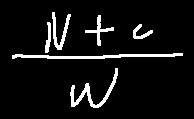

In [13]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][1]).convert("RGB")
image


In [15]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

\frac { N + c } { w }


In [13]:
from transformers import VisionEncoderDecoderModel
#microsoft/trocr-small-handwritten
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1") #microsoft/trocr-base-stage1

model

Downloading: 100%|██████████| 4.11k/4.11k [00:00<00:00, 2.37MB/s]
Downloading: 100%|██████████| 235M/235M [00:31<00:00, 7.72MB/s]   
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0): DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=

In [14]:
model.config

VisionEncoderDecoderConfig {
  "_name_or_path": "microsoft/trocr-small-stage1",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "relu",
    "add_cross_attention": true,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": 384,
    "d_model": 256,
    "decoder_attention_heads": 8,
    "decoder_ffn_dim": 1024,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 6,
    "decoder_start_token_id": 2,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.1,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "init_st

In [15]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
#model.config.max_length = 200 # origin 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 2
model.config.length_penalty = 2.0
model.config.num_beams = 5

In [13]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8, #origin 8
    per_device_eval_batch_size=1, #origin 8
    fp16=True, 
    output_dir="./checkpoint_eval_2014_small_stage1/",
    logging_steps=2,
    save_steps=1000,
    eval_steps=500,
    num_train_epochs = 100,
)

In [ ]:
#from datasets import load_metric

#cer_metric = load_metric("cer")
#cer_metric = load_metric("accuracy")

In [ ]:
'''
import numpy as np

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}
'''
'''
def compute_metrics(pred):
    predictions= pred.predictions
    labels = pred.label_ids
    predictions = np.argmax(predictions, axis=1)
    return cer_metric.compute(predictions=predictions, references=labels)
'''

In [14]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    #compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train() #"checkpoint-9000"   "checkpoint_eval_2014/checkpoint-12000"

Using amp half precision backend
***** Running training *****
  Num examples = 8835
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 110500
/usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:383: UserWarning: Could not estimate the number of tokens of the input, floating-point operations will not be computed
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/trainer.py:1364: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

Inference

In [30]:
#tensorboard --logdir checkpoint_eval_2014/

SyntaxError: invalid syntax (2162057466.py, line 1)

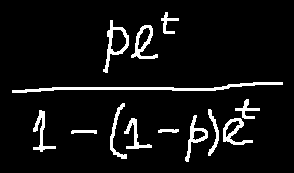

In [14]:
#predictions = trainer.predict(eval_dataset)
image = Image.open(eval_dataset.root_dir + test_df['file_name'][3]).convert("RGB")
image

In [17]:
encoding = eval_dataset[3]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [18]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

\frac { p e ^ { t } } { 1 - ( 1 - p ) e ^ { t } }


In [ ]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("./checkpoint-9000")


In [ ]:
def ocr_image(src_img):
  pixel_values = processor(images=src_img, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values)
  return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


In [ ]:
ocr_image(image)

'x _ { 1 } - x _ { 2 } + y _ { 3 } + z _ { 4 } - z _'